This is TensorFlow example code from [`word2vec_basic.py`](https://github.com/tensorflow/tensorflow/blob/r1.3/tensorflow/examples/tutorials/word2vec/word2vec_basic.py) for the [Vector Representations of Words](https://www.tensorflow.org/tutorials/word2vec) tutorial.

### What are word embeddings?

A **word embedding** is way to represent words as _vectors_, rather than as simple unique _integers_.

The advantage of representing a word as a vector is that words with similar meanings can be mapped to a close-by vector. This way semantic similarities between words can be easily captured, which is not possible if simple integers were used.

### What is a Skip-Gram model?

Let's first define an **N-Gram** model, such as 1-Gram or 2-Gram (also known as a "bigram"). These are models where the probability of a word occurring in a position in a text is assumed to depend on the previous word (1-Gram) or the two previous words (2-Gram), and so on for any arbitrary N.

A **Skip-Gram** model is an extension to the N-Gram model and does not consider the previous N words to predict the probability of a next word, but it _skips_ words. So instead of considering the previous word (1-Gram), it may skip that word and look at the one before it.

See [What is a skip-gram model?](https://www.quora.com/What-is-a-skip-gram-model-Why-is-it-better-than-other-language-models-And-how-does-it-work) and [What are skip-gram models?](https://www.quora.com/What-are-skip-gram-models) on Quora.

In [1]:
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Step 1: Download the data.

Our vocabulary text consists of a little over 17,000,000 non-unique words. The `vocubulary` is a list of Unicode words (that's what the `tf.compat.as_str` does):

In [2]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)


# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Found and verified text8.zip
Data size 17005207


## Step 2: Build the dictionary and replace rare words with UNK token.

We use the `Counter` class to create a dictionary of the most common 50,000 words. This `dictionary` maps each common word to a unique index (i.e. the `len(dictionary)`, which changes as we add words - in effect the index in our text where the word first occurs).

Every word in the text that is not in our dictionary is treated as an unknown word and maps to `UNK`.

The `data` is a transformation of the list of `words` of our text to a list of indexes.

The `count` is a histogram of the most common 50,000 words, containing 50,000 `[word, count]` items. The first item is `['UNK', count]`, the number of unknown words.

The `reverse_dictionary` maps indexes to words.

In [3]:
vocabulary_size = 50000


def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))

    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count

    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


The first words of our text, with their indexes, are:

| anarchism | originated | as | a | term | of | abuse | first | used | against |
|:---------:|:----------:|:--:|:-:|:----:|:--:|:-----:|:-----:|:----:|:-------:|
| 5234      | 3081       | 12 | 6 | 195  | 2  | 3134  | 46    | 59   | 156     |

## Step 3: Function to generate a training batch for the skip-gram model.

The `generate_batch` function below creates a single batch of `batch_size` target mappings (i.e. which word is predicted by which other surrounding word or words).

The number of surrounding words to choose from is governed by the value of `skip_window`. A value of one, for instance, will mean one word to the left _and_ one word to the right will be considered. A value of two would mean two words to the left _and_ two words to the right, and so on.

For example, when `skip_window=1` the total window size will be _three_:
1. one word to the left
2. the word itself
3. one word to the right

This window slides over the text, one word at a time, starting at the word at `data_index`. For `skip_window=1`, initially `data_size=0` and the window would be filled with first three words of our text, with **originated** being the word we want to map to its neighbours:

| 1         | 2              | 3  |
|:---------:|:--------------:|:--:|
| anarchism | **originated** | as |
| 5234      | 3081           | 12 |

If `skip_window=2`, we'd have a window size of five, looking like:

| 1         | 2              | 3      | 4 | 5    |
|:---------:|:--------------:|:------:|:-:|:----:|
| anarchism | originated     | **as** | a | term |
| 5234      | 3081           | 12     | 6 | 195  |

We'd start with **as** in this case, since we want to be able to look two words to the left (and right, of course).

How many of the surrounding words are picked is determined by `num_skips`. When two, for example, two words are picked randomly, within the window determined by `skip_window`.

For example, when `num_skips=2` and `skip_window=1` as above, the function will have no choice but to pick the left word and the right word, since those are the only two options:

| word            | maps to        |
|:---------------:|:--------------:|
| 3081 originated | 12 as          |
| 3081 originated | 5234 anarchism |

In [4]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
  
    batch  = np.ndarray(shape=(batch_size),    dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    
    # Create a dequeu (pronounced "deck", for double-ended queue) for fast
    # pushes and pops on either end, the size of 'span' indexes for words
    # in our text. This is like a window that moves over the text.
    buffer = collections.deque(maxlen=span)
    
    # Wrap around the text when at the end.
    if data_index + span > len(data):
        data_index = 0
        
    # Fill the deck with the indexes of 'span' words of our text; these are
    # the first 'span' words when data_index is zero.
    buffer.extend(data[data_index:data_index + span])
    
    # Move to the next 'span' words.
    data_index += span
  
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        
        # Don't map a word to itself. Note that `skip_window` is the center
        # index into `buffer`.
        targets_to_avoid = [skip_window]

        # Each target maps to `num_skips` words in the window of size `span`.
        for j in range(num_skips):
            # Generate a random index in the window on our text, skipping
            # any words we want to avoid, such as words we already mapped.
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            
            # Don't map this word again.
            targets_to_avoid.append(target)

            batch[ i * num_skips + j]    = buffer[skip_window]  # This word...
            labels[i * num_skips + j, 0] = buffer[target]       # maps to this neighbor.
    
        # Move the window one word on.
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1

    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


## Step 4: Build and train a skip-gram model.

In [5]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.global_variables_initializer()

## Step 5: Begin training.

In [6]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  261.481628418
Nearest to i: schloss, semitone, barrier, pretext, safety, handheld, cps, ithaca,
Nearest to UNK: classifying, lamas, iers, dalai, kwame, tut, shapur, fabrics,
Nearest to state: mosquitos, babrak, fallen, onstage, peyton, calvert, cerebral, arturo,
Nearest to for: disavowed, metabolites, batavians, tonk, piercer, egyptologist, dks, interconnect,
Nearest to three: defector, pharmacies, gradually, specifications, expiring, removal, incoherent, edmond,
Nearest to that: motorists, poitou, purana, extrusive, heater, herold, neum, pragmatic,
Nearest to to: broadcasted, plankton, karelian, periodically, hawkwind, sitar, hostility, keating,
Nearest to would: cubism, sourceforge, ego, shares, majorana, louisa, pencil, dll,
Nearest to use: zephaniah, jungingen, witch, mull, sterne, leblanc, kennedys, atheists,
Nearest to over: ties, secam, chiuchow, karst, formats, superfluid, correlated, akhenaten,
Nearest to may: nexus, given, terrible, pred

Average loss at step  52000 :  5.04698954093
Average loss at step  54000 :  5.20142587614
Average loss at step  56000 :  5.05090287912
Average loss at step  58000 :  5.05652821314
Average loss at step  60000 :  4.9770341928
Nearest to i: barrier, energies, binding, t, dasyprocta, percival, safety, UNK,
Nearest to UNK: agouti, circ, dasyprocta, amalthea, kapoor, wct, michelob, operatorname,
Nearest to state: ursus, circ, filmmakers, compare, dasyprocta, michelob, operatorname, fallen,
Nearest to for: batavians, ursus, in, or, of, with, five, after,
Nearest to three: four, six, five, two, seven, eight, one, operatorname,
Nearest to that: which, however, this, but, operatorname, circ, kapoor, archie,
Nearest to to: will, for, into, dasyprocta, can, would, nine, from,
Nearest to would: will, can, could, may, to, operatorname, might, dasyprocta,
Nearest to use: agouti, witch, twh, wct, operatorname, michelob, hydrophilic, roshan,
Nearest to over: nixon, through, superfluid, about, noaa, urs

## Step 6: Visualize the embeddings.

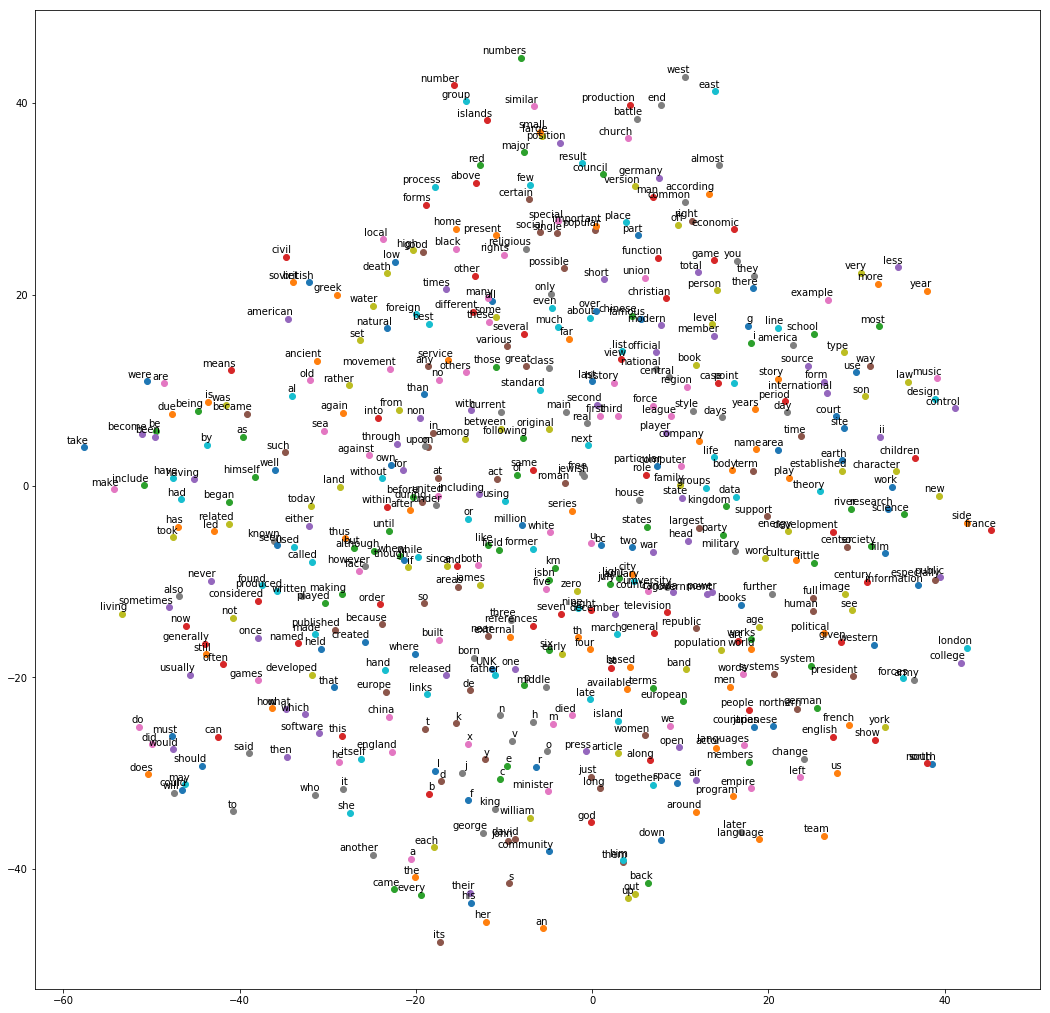

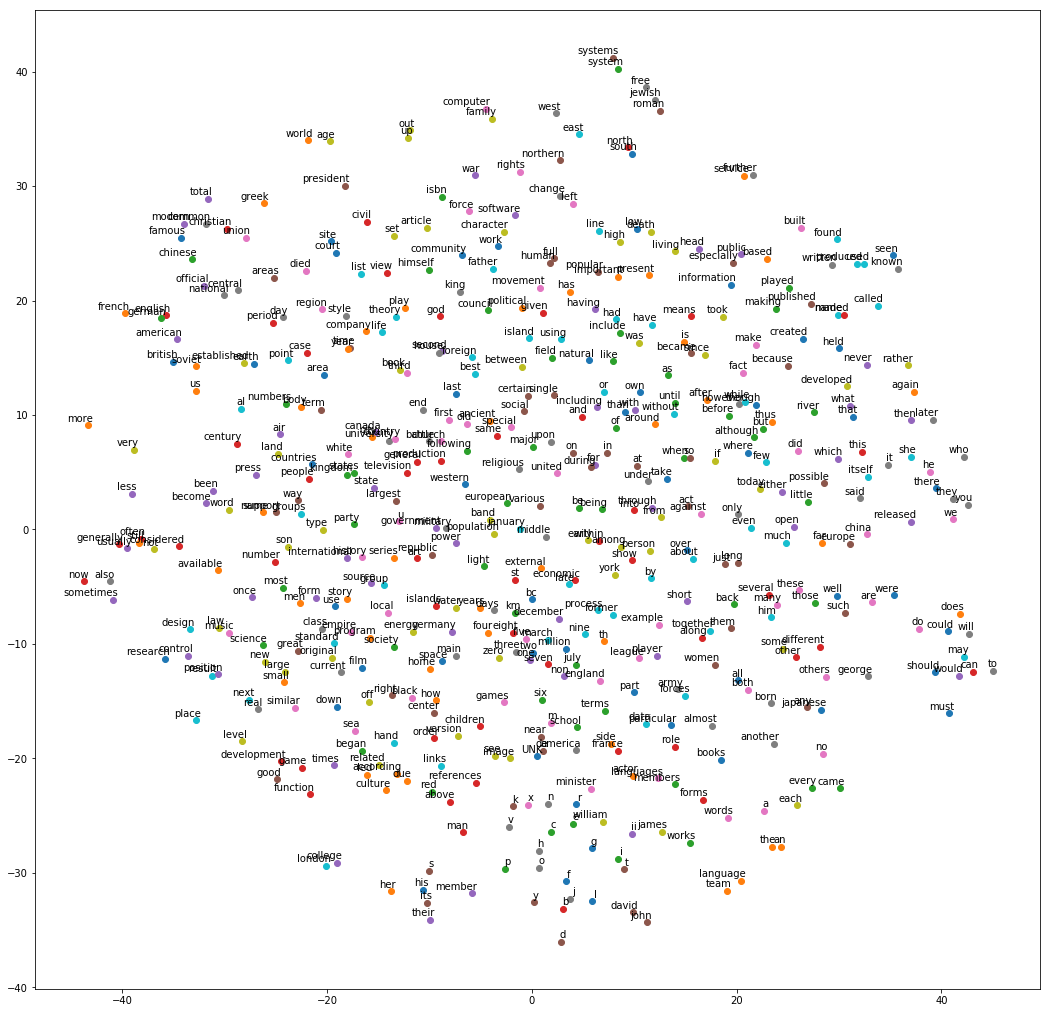

In [8]:
def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.show()

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)